# Working Version From Machinelearning mastery

In [1]:
# SG Sigmoid in Generator 
# SL Soft Labels
# GN Gaussian Noise (not uniform)
# OHE One Hot Encoding
# Replaced Concatenate with multiply

# TODO
# basic conditional gan
# generate data
# add and train a classifier use k fold also
# condition me one hot encoding
# generator k lie combined data and disc k lie train data.. coz testing me sara deke bias ho jaega
# different loss functions for generator and discriminator
# discriminator output shud be one hot encode with labels as n s or v and not 0 or 1 that is fake or real:
# confusion here
# disc property: should recognise fake and also if gen data is not of that class (so 2 things)
# training k time jab random samples uthaenge tab sari classes k
# equal no. of samples uthana

In [2]:
%config Completer.use_jedi = False

import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
import keras
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Reshape, multiply, Embedding, merge, Concatenate, Conv1D, BatchNormalization
from keras.layers import Dense, Flatten, Multiply
from keras.layers.advanced_activations import LeakyReLU
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt

In [3]:
# in_label = Input(shape=(input_classes,))
# x = Embedding(input_classes, 30)(in_label)
# x = Dense(int(data_dim/input_classes))(x)
# x = Reshape((data_dim,1))(x) 

In [4]:
def discriminator(data_dim, input_classes=3):
    
#     in_label = Input(shape=(1,))
#     x = Embedding(input_classes, 30)(in_label)
#     x = Dense(data_dim)(x)
#     x = Reshape((data_dim,1))(x)
    
    in_label = Input(shape=(input_classes,))
    x = Embedding(input_classes, 30)(in_label)
    x = Dense(int(data_dim/input_classes))(x)
    x = Reshape((data_dim,1))(x)
    
    D_in = Input(shape=[data_dim,1])
#     x = Multiply()([D_in, x])
    x = Concatenate()([D_in, x])
    
    x = Conv1D(filters=32, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters=32*2, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters=32*4, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters=32*8, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv1D(filters=32*16, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Flatten()(x)
    out = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=[D_in, in_label], outputs=out)
    opt = Adam(lr=0.0002, beta_1=0.5)
    loss = 'binary_crossentropy'
    model.compile(loss=loss, optimizer=opt, metrics=['accuracy'])
    return model

# d_model = discriminator(data_dim=186, input_classes=3)
# plot_model(d_model, to_file='disc.pdf', show_shapes=True)

In [5]:
# noise_dim=100
# in_label = Input(shape=(input_classes,))
# print (in_label.shape)
# x = Embedding(1, 30)(in_label)
# print (x.shape)
# x = Dense(100)(x)
# print (x.shape)
# x = Reshape((noise_dim,1))(x)    
# print (x.shape)

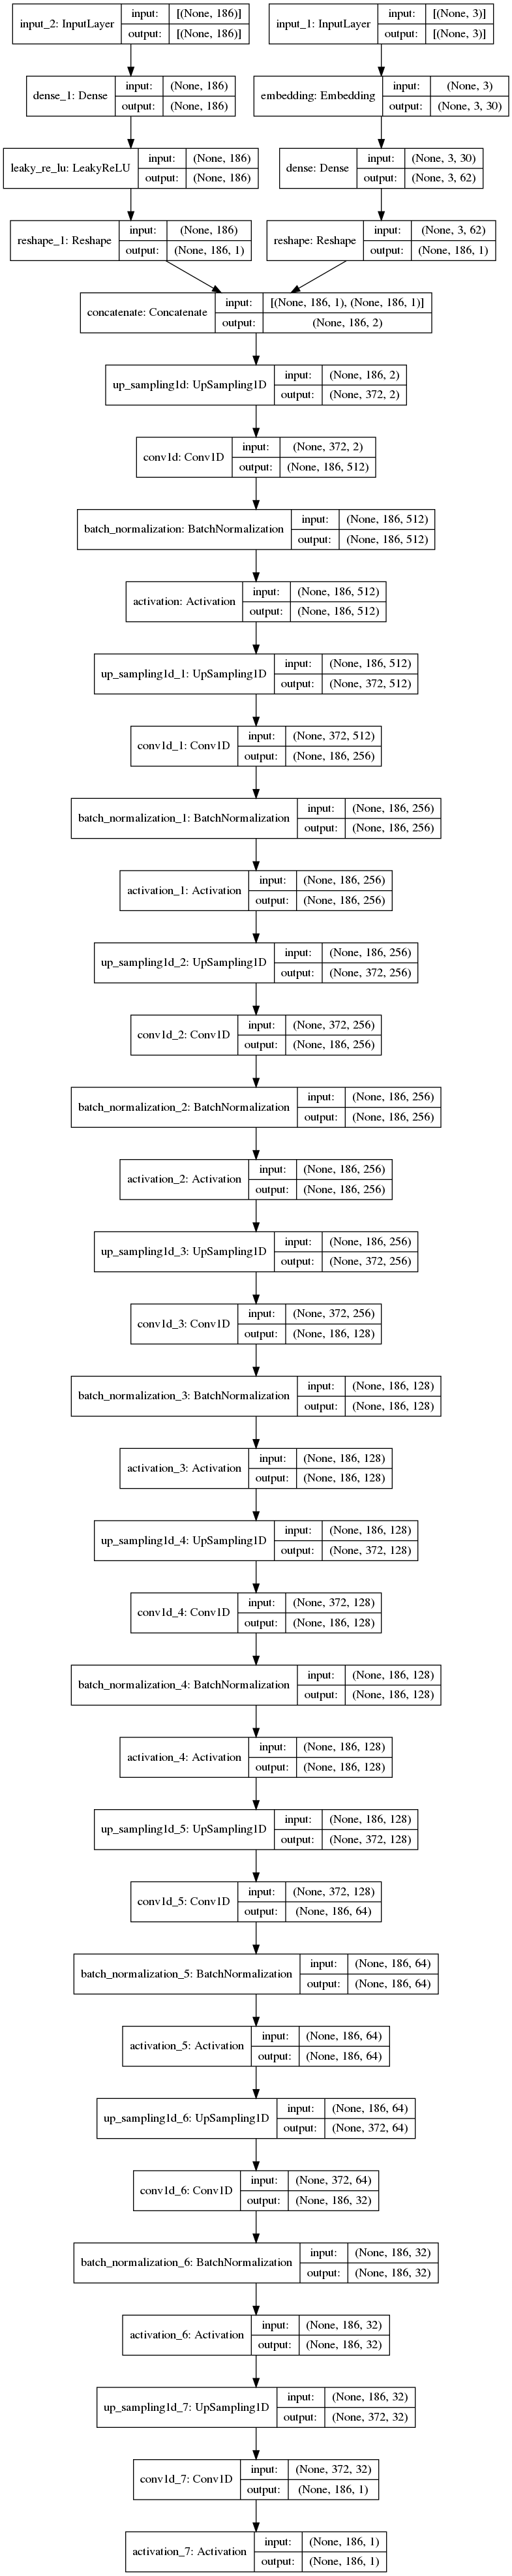

In [6]:
from keras.layers import UpSampling1D
from keras.layers.core import Activation
from keras.layers import Add
import tensorflow as tf

def generator(noise_dim=99, input_classes=3, out_dim=186):
    
#     in_label = Input(shape=(1,))
#     x = Embedding(input_classes, 30)(in_label)
#     x = Dense(noise_dim)(x)
#     x = Reshape((noise_dim,1))(x)
    
    in_label = Input(shape=(input_classes,))
    x = Embedding(input_classes, 30)(in_label)
    x = Dense(int(noise_dim/input_classes))(x)
    x = Reshape((noise_dim,1))(x)    
    
    G_in = Input(shape=[noise_dim,])
    gen = Dense(noise_dim)(G_in)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((noise_dim,1))(gen)

#     x = Multiply()([gen, x])
    x = Concatenate()([gen, x])
    
    x = UpSampling1D()(x)
    x = Conv1D(filters=32*16, kernel_size=2, strides=2, padding='valid', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = UpSampling1D()(x)
    x = Conv1D(filters=32*8, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(filters=32*8, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(filters=32*4, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(filters=32*4, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(filters=32*2, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(filters=32, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling1D()(x)
    x = Conv1D(filters=1, kernel_size=4, strides=2, padding='same', kernel_initializer='he_normal')(x)
    out = Activation('sigmoid')(x)  # for tanh change here
    model = Model(inputs=[G_in, in_label], outputs=out)

    return model

g_model = generator(noise_dim=186, input_classes=3, out_dim=186)
plot_model(g_model, to_file='gen.png', show_shapes=True)

In [7]:
def create_gan(d_model, g_model):
    
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    loss = 'binary_crossentropy'
    model.compile(loss=loss, optimizer=opt)
    return model

# gan_model = create_gan(d_model, g_model)
# plot_model(gan_model, to_file='gan.pdf', show_shapes=True)

In [8]:
def load_real_samples():
    X = np.load('Data/X.npy')
    y = np.load('Data/y.npy')

    # print (X.shape, y.shape)

    X_N = X[y==0]
    X_S = X[y==1]
    X_V = X[y==2]

    y_N = y[y==0]
    y_S = y[y==1]
    y_V = y[y==2]

    # print (X_N.shape, y_N.shape)
    # print (X_S.shape, y_S.shape)
    # print (X_V.shape, y_V.shape)

    X_N=X_N.reshape(X_N.shape[0],X_N.shape[1],1)
    X_S=X_S.reshape(X_S.shape[0],X_S.shape[1],1)
    X_V=X_V.reshape(X_V.shape[0],X_V.shape[1],1)

    # print (X_N.shape, y_N.shape)
    # print (X_S.shape, y_S.shape)
    # print (X_V.shape, y_V.shape)
    return X_N, y_N, X_S, y_S, X_V, y_V

In [9]:
def generate_real_samples(X_N, y_N, X_S, y_S, X_V, y_V, n_samples):
    
    # choose random instances
    i_N = randint(0, y_N.shape[0], int(n_samples/3))
    i_S = randint(0, y_S.shape[0], int(n_samples/3))
    i_V = randint(0, y_V.shape[0], int(n_samples/3))
    
    # select ECG and labels
    X = np.vstack((X_N[i_N], X_S[i_S], X_V[i_V]))
    labels = np.hstack((y_N[i_N], y_S[i_S], y_V[i_V]))
    labels = keras.utils.to_categorical(labels)
    # print (labels.shape)
    
    # generate class labels
    y = np.random.uniform(0.7, 1, n_samples)
    y = y.reshape(y.shape[0], 1)
#     y = np.ones((n_samples, 1))
    return [X, labels], y

In [10]:
def reshape(X):
    if len(X.shape) == 1:
        X = X.reshape(X.shape[0], 1)
        return X
    else:
        if X.shape[-1] == 1:
            return X
        else:
            X = X.reshape(X.shape[0], X.shape[1], 1)
            return X

# generate points in latent space as input for the generator
# normal noise
def generate_latent_points(latent_dim, n_samples, n_classes=3):
    # generate points in the latent space
#     X_fake = np.random.uniform(0, 1.0, size=[n_samples, latent_dim])
    X_fake = np.random.normal(0,1.0,(n_samples,latent_dim))
    # generate labels
    labels_fake = np.hstack((np.zeros(int(n_samples/3)), np.ones(int(n_samples/3)), 2*np.ones(int(n_samples/3))))
    np.random.shuffle(labels_fake)
    labels_fake = keras.utils.to_categorical(labels_fake)
    return [reshape(X_fake), labels_fake]

In [11]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = np.random.uniform(0, 0.3, n_samples)
    y = y.reshape(y.shape[0], 1)
#     y = np.zeros((n_samples, 1))
    return [images, labels_input], y

In [12]:
# create and save a plot of generated images
def save_plot(X, n):
    plt.figure(figsize=(10,3))
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.plot(X[i, :, 0])
    plt.show()
    plt.close()

In [13]:
def get_real_samples(X_N, y_N, X_S, y_S, X_V, y_V):
    
    # choose random instances
    i_N = randint(0, y_N.shape[0], 1)
    i_S = randint(0, y_S.shape[0], 1)
    i_V = randint(0, y_V.shape[0], 1)
    
    # select ECG and labels
    X = np.vstack((X_N[i_N], X_S[i_S], X_V[i_V]))
    return X

def save_new_plot(X, n, name):
    plt.figure(figsize=(15,5))
    for i in range(n-1):
        plt.subplot(n+1, n-1, 1 + i)
        plt.axis('off')
        plt.plot(X[i, :, 0])
    for i in range(3, (n*n)-n):
        # define subplot
        plt.subplot(n+1, n-1, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.plot(X[i, :, 0])
    plt.savefig(name, dpi=50)
    plt.close()

In [ ]:
# size of the latent space
latent_dim = 186
# size of the data
data = 186
# classes
classes = 3

n_epochs=50

# multiples of three (three classes) (less thyan 24000)
n_batch=300

# samples to watch
n=3

# Loss Values
D_L_1 = np.infty
D_L_2 = np.infty
G_L = np.infty

# create the discriminator
d_model = discriminator(data_dim=data, input_classes=classes)
# create the generator
g_model = generator(noise_dim=latent_dim, input_classes=classes, out_dim=data)
# create the gan
gan_model = create_gan(d_model, g_model)

# load image data
X_N, y_N, X_S, y_S, X_V, y_V = load_real_samples()
# # train model
# train(g_model, d_model, gan_model, dataset, latent_dim)

bat_per_epo = int(y_S.shape[0] / n_batch)
half_batch = int(n_batch / 2)
flag=0

# losses = []
plt.ioff()

filename = 'Basic_CGAN_Sigmoid_OHE'

if not os.path.isdir(filename):
    os.mkdir(filename)

f = open(filename + '_Loss.csv', 'w')
f.write('d_loss1, d_loss2, g_loss \n')
f.close()

# manually enumerate epochs
for i in range(n_epochs):
    # enumerate batches over the training set
    for j in range(bat_per_epo):
        # get randomly selected 'real' samples
        [X_real, labels_real], y_real = generate_real_samples(X_N, y_N, X_S, y_S, X_V, y_V, half_batch)
        # print (X_real.shape, labels_real.shape, y_real.shape)
        # update discriminator model weights
        d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
        # generate 'fake' examples
        [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        # print (X_fake.shape, labels.shape, y_fake.shape)
        # update discriminator model weights
        d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
        # prepare points in latent space as input for the generator
        [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
        # print (z_input.shape, labels_input.shape)
        # create inverted labels for the fake samples
        y_gan = np.random.uniform(0.7, 1, n_batch)
        y_gan = y_gan.reshape(y_gan.shape[0], 1)
        # y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
        
        if g_loss < G_L:
            D_L_1 = d_loss1
            D_L_2 = d_loss2
            G_L = g_loss
            g_model.save(filename + '_cgan_generator.h5')
            
            
#         losses.append((d_loss1, d_loss2, g_loss))
        f = open(filename + '_Loss.csv', 'a')
        f.write(str(d_loss1)+','+str(d_loss2)+','+str(g_loss)+'\n')
        f.close()
        
        # summarize loss on this batch
        if (j+1)%2 == 0:
            print('>%d, %d/%d, d1=%.5f, d2=%.5f g=%.5f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
#         if (j+1)%5 == 0:
            name = filename + '/'+str(i*1000 + j)+'.jpg'
            # generate images
            latent_points, labels = generate_latent_points(latent_dim, n*n)
            # specify labels
            labels = asarray([x for _ in range(n) for x in range(n)])
            # generate images
            X  = g_model.predict([latent_points, keras.utils.to_categorical(labels)])
            X_R = get_real_samples(X_N, y_N, X_S, y_S, X_V, y_V)
            X = np.vstack((X_R, X))
            save_new_plot(X, n+1, name)

>1, 2/80, d1=0.47596, d2=0.82926 g=0.70702
>1, 4/80, d1=0.46864, d2=0.50505 g=0.70755
>1, 6/80, d1=0.46359, d2=0.46348 g=0.68930
>1, 8/80, d1=0.46517, d2=0.44841 g=0.62084
>1, 10/80, d1=0.45504, d2=0.41878 g=0.56530
>1, 12/80, d1=0.41324, d2=0.47142 g=0.52444
>1, 14/80, d1=0.45641, d2=0.43705 g=0.50455
>1, 16/80, d1=0.43419, d2=0.44387 g=0.47827
>1, 18/80, d1=0.43150, d2=0.45884 g=0.45959
>1, 20/80, d1=0.40565, d2=0.45843 g=0.45659
>1, 22/80, d1=0.44976, d2=0.45721 g=0.46264
>1, 24/80, d1=0.42759, d2=0.44132 g=0.44198
>1, 26/80, d1=0.42909, d2=0.44799 g=0.44223
>1, 28/80, d1=0.44764, d2=0.44031 g=0.44774
>1, 30/80, d1=0.44004, d2=0.44395 g=0.48568
>1, 32/80, d1=0.44762, d2=0.43780 g=0.45975
>1, 34/80, d1=0.44611, d2=0.45440 g=0.45190
>1, 36/80, d1=0.47876, d2=0.42551 g=0.46144
>1, 38/80, d1=0.46148, d2=0.44424 g=0.44404
>1, 40/80, d1=0.45254, d2=0.42555 g=0.44203
>1, 42/80, d1=0.47724, d2=0.43126 g=0.46708
>1, 44/80, d1=0.48182, d2=0.44289 g=0.46056
>1, 46/80, d1=0.45278, d2=0.44283 g=

>5, 56/80, d1=0.41614, d2=0.44273 g=0.43541
>5, 58/80, d1=0.43984, d2=0.42817 g=0.44025
>5, 60/80, d1=0.41255, d2=0.43824 g=0.42779
>5, 62/80, d1=0.43534, d2=0.43092 g=0.41548
>5, 64/80, d1=0.41396, d2=0.44110 g=0.43729
>5, 66/80, d1=0.41398, d2=0.44796 g=0.43249
>5, 68/80, d1=0.41086, d2=0.40890 g=0.42696
>5, 70/80, d1=0.41108, d2=0.44140 g=0.42336
>5, 72/80, d1=0.44361, d2=0.48373 g=0.44274
>5, 74/80, d1=0.43143, d2=0.44061 g=0.40668
>5, 76/80, d1=0.41753, d2=0.42854 g=0.43138
>5, 78/80, d1=0.42276, d2=0.43846 g=0.43049
>5, 80/80, d1=0.42013, d2=0.46645 g=0.41817
>6, 2/80, d1=0.44628, d2=0.46424 g=0.45970
>6, 4/80, d1=0.41341, d2=0.45923 g=0.44607
>6, 6/80, d1=0.41875, d2=0.43926 g=0.41971
>6, 8/80, d1=0.43407, d2=0.45931 g=0.44405
>6, 10/80, d1=0.43419, d2=0.47804 g=0.42563
>6, 12/80, d1=0.43084, d2=0.45922 g=0.43546
>6, 14/80, d1=0.41405, d2=0.44041 g=0.42926
>6, 16/80, d1=0.41774, d2=0.43229 g=0.43380
>6, 18/80, d1=0.43319, d2=0.44999 g=0.43927
>6, 20/80, d1=0.42732, d2=0.43001 g=

>10, 30/80, d1=0.44520, d2=0.42430 g=0.43984
>10, 32/80, d1=0.44320, d2=0.42407 g=0.43137
>10, 34/80, d1=0.43215, d2=0.42179 g=0.42863
>10, 36/80, d1=0.42026, d2=0.43752 g=0.42561
>10, 38/80, d1=0.42665, d2=0.43058 g=0.42766
>10, 40/80, d1=0.43024, d2=0.41802 g=0.41613
>10, 42/80, d1=0.40925, d2=0.43277 g=0.41675
>10, 44/80, d1=0.44942, d2=0.42673 g=0.41375
>10, 46/80, d1=0.41051, d2=0.42809 g=0.44332
>10, 48/80, d1=0.42495, d2=0.42761 g=0.47707
>10, 50/80, d1=0.43995, d2=0.45049 g=0.42310
>10, 52/80, d1=0.42889, d2=0.45187 g=0.44594
>10, 54/80, d1=0.42791, d2=0.42426 g=0.42294
>10, 56/80, d1=0.42331, d2=0.42860 g=0.44297
>10, 58/80, d1=0.40932, d2=0.43442 g=0.42919
>10, 60/80, d1=0.43620, d2=0.44632 g=0.45431
>10, 62/80, d1=0.40457, d2=0.43550 g=0.44944
>10, 64/80, d1=0.42357, d2=0.44252 g=0.42961
>10, 66/80, d1=0.43854, d2=0.43389 g=0.40834
>10, 68/80, d1=0.41119, d2=0.41804 g=0.43667
>10, 70/80, d1=0.44516, d2=0.42085 g=0.42860
>10, 72/80, d1=0.42309, d2=0.43268 g=0.41889
>10, 74/80

In [ ]:
# from evaluation_metrics import *
# metric_to_calculate = ['FID', 'MMD', 'DTW', 'ED', 'PC', 'KLD', 'RMSE', 'TWED']
# f = open(data_dir+'Stats.csv', 'a')
# f.write('Epoch, d_loss1, d_loss2, g_loss, ')
# for i in range(len(label_dict)):
#     for mtc in metric_to_calculate:
#         f.write(str(mtc)+str(i)+',')
# f.write('Time,\n')
# f.close()

# d_loss1 = float(d_loss1.history['loss'][0])
# d_loss2 = float(d_loss2.history['loss'][0])
# g_loss = float(g_loss.history['loss'][0])

# if i%checkpoint == 0:
        
#         f = open(data_dir+'Stats.csv', 'a')
#         f.write(str(i+1)+','+str(d_loss1)+','+str(d_loss2)+','+str(g_loss)+',')
#         save_model(model=G, data_dir=data_dir, type='G', epoch=i)
#         save_model(model=D, data_dir=data_dir, type='D', epoch=i)
#         save_model(model=GAN, data_dir=data_dir, type='GAN', epoch=i)
        
#         for k,metric in enumerate(label_dict.keys()):    
#             temp_x = test_data[200*(k):200*(k+1),:-1]
#             [z_input, labels_input] = generate_class_specific_latent_input(200, n_classes=n_classes, noise_dim=noise_dim, category=float(metric))
#             z_input = G.predict([z_input, labels_input], verbose=verbose)

#             for j in range(2):
#                 plt.plot(z_input[j])
#             plt.savefig(data_dir+str(i)+'_Label_'+str(metric)+'.png')
#             plt.close()
#             plt.clf()
            
#             results = evaluate(temp_x,z_input,metric_to_calculate)
#             for r in results:
#                 f.write(str(r)+',')
            
#         f.write(str(end-start)+'\n')
#         f.close()

In [ ]:
# #     # save the generator model
#     g_model.save('cgan_generator.h5')

# callback = [EarlyStopping(monitor='val_AUC', mode='max', verbose=1, patience=Pat),
#          ModelCheckpoint(filepath=str(twelve_lead_model_filename)+'_check_model.h5', 
#                          monitor='val_AUC', verbose=1, save_best_only=True, mode='max'),
#          ReduceLROnPlateau(monitor='val_AUC', factor=0.5, patience=Pat//2, verbose=1, 
#                            mode='max', min_delta=0.0001, cooldown=0, min_lr=0)]

# # model = parallel_NN(WINDOW_SIZE,INPUT_FEAT,OUTPUT_CLASS):
# model = parallel_NN(Window, len(leads), snomed_classes.shape[0])

# model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
#               optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
#               metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy', dtype=None, threshold=0.5),
#                        tf.keras.metrics.Recall(name='Recall'),
#                        tf.keras.metrics.Precision(name='Precision'),
#                        tf.keras.metrics.AUC(num_thresholds=200,summation_method="interpolation",
#                                             name="AUC",dtype=None,curve="ROC",thresholds=None,
#                                             multi_label=True,label_weights=None)])
# history = model.fit(train_generator, steps_per_epoch=train_samples, epochs=EP, verbose=1,
#                 validation_data=val_generator, validation_steps=val_samples, callbacks=callback)


# history_name = output_directory + '/' + twelve_lead_filename
# print (twelve_lead_model_filename, history_name)

# save_model(twelve_lead_model_filename, model)
# write_history(history_name, history.history)